# EMNIST_Word_Predictor
In this project I will be building a model that predicts a single line word containing up to 5 characters (letters or digits). It makes use of the Extended MNIST balanced dataset which consists of images of 47 characters (10 digits, 26 uppercase letters and 11 lowercase letters). These images are used to create synthetic words by concatenating images of random characters to form word images (not necessarily meaningful words).

The EMNIST is a pretty common dataset but to do something different, the dataset will be used to predict the string or word present in an image by first predicting the number of characters which is present in the image and then using appropriate models to predict the characters hence the word.

The total dataset (emnist_by_class) which contains all the 26 uppercase and lowercase letters and the 10 digits was not used for this project due to the limited compute resources available.

The character images present in this dataset are:
 0 1 2 3 4 5 6 7 8 9 A B C D E F    G H I J K L M N O P Q R S T U  V W X Y Z a b d e f g h n q r t

 **Please note the dataset is not attached to the dataset directory as it is too large. You can get it form [kaggle](https://www.kaggle.com/datasets/crawford/emnist) or from [tensorflow_dataset](https://www.tensorflow.org/datasets/catalog/emnist) which is illustrated in the notebook.**


### Importing the required libraries.

In [ ]:
# Mounting my google drive to access my data.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time

from os.path import join
from os import listdir

from tensorflow.image import resize
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.nn import softmax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

### Defining required variables.

In [ ]:
emnist_width, emnist_height = 28, 28 # The emnist image shaoe
image_width, image_height = 64, 64
image_channel = 1

MAX_NUMBER_CHARATER = 5
NO_CHARATERS = 47

In [ ]:
root_dir = "/content/drive/MyDrive/EMNIST_Word_Predictor"

model_dir = join(root_dir, "Models")
dataset_dir = join(root_dir, "emnist_balanced_dataset")

train_dataset_path  = join(dataset_dir, "emnist-balanced-train.csv")
val_dataset_path  = join(dataset_dir, "emnist-balanced-test.csv")
mapping_path = join(dataset_dir, "emnist-balanced-mapping.txt")

## Reading the dataset.
For this project I have the dataset downloaded to my drive and I will be reading that.
- The dataset is stored in a directory named "emnist_bybalance_dataset".
- It is divided into the train and test set each in a separate csv file.

You can also load the dataset from the tensorflow_dataset by running the commented code block below the next. The dataset is returned as a dict of `tensorflow.python.data.ops.prefetch_op._PrefetchDataset`.

In [ ]:
train_dataset  = pd.read_csv(train_dataset_path, header=None)
val_dataset  = pd.read_csv(val_dataset_path, header=None)

In [ ]:
# import tensorflow_datasets as tfds
# datasets, info = tfds.load(name="emnist/balanced", with_info=True, as_supervised=True)

# train_dataset, val_dataset = datasets["train"], datasets["test"]

### Understanding the dataset
- The first column of the dataset contains the labels of the image as the decimal value of their ascii codes.
- The image's pixel values are contained in the remaining 784 (28*28) columns.
- Each character has 2400 training images.

In [ ]:
print(f"The shape of the train dataset is {train_dataset.shape}. \nThe shape of the test dataset is {val_dataset.shape}")

The shape of the train dataset is (112800, 785). 
The shape of the test dataset is (18800, 785)


In [ ]:
train_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Extracting the images columns and label columns, converting them to numpy arrays and reshaping them to be 2D arrays.

In [ ]:
images_train, labels_train  = train_dataset.iloc[:, 1:].to_numpy(), train_dataset.iloc[:, 0].to_numpy()
images_val, labels_val = val_dataset.iloc[:, 1:].to_numpy(), val_dataset.iloc[:, 0].to_numpy()

In [ ]:
images_train.shape, labels_train.shape, images_val.shape, labels_val.shape

((112800, 784), (112800,), (18800, 784), (18800,))

In [ ]:
images_train = images_train.reshape(images_train.shape[0], emnist_width, emnist_height)
images_val = images_val.reshape(images_val.shape[0], emnist_width, emnist_height)
print(f"The shape of the reshaped image is {images_train.shape}")

The shape of the reshaped image is (112800, 28, 28)


In [ ]:
np.unique(labels_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

In [ ]:
for i, label in enumerate(np.unique(labels_train)):
  end = "\t" if i%6 != 5 else "\n"
  print(f"{label:2d} - {(labels_train == label).sum()}", end=end)

 0 - 2400	 1 - 2400	 2 - 2400	 3 - 2400	 4 - 2400	 5 - 2400
 6 - 2400	 7 - 2400	 8 - 2400	 9 - 2400	10 - 2400	11 - 2400
12 - 2400	13 - 2400	14 - 2400	15 - 2400	16 - 2400	17 - 2400
18 - 2400	19 - 2400	20 - 2400	21 - 2400	22 - 2400	23 - 2400
24 - 2400	25 - 2400	26 - 2400	27 - 2400	28 - 2400	29 - 2400
30 - 2400	31 - 2400	32 - 2400	33 - 2400	34 - 2400	35 - 2400
36 - 2400	37 - 2400	38 - 2400	39 - 2400	40 - 2400	41 - 2400
42 - 2400	43 - 2400	44 - 2400	45 - 2400	46 - 2400	

### Extracting the labels to their corresponding ascii label for the mapping text file.

In [ ]:
mapping_dict = {}
with open(mapping_path, 'r') as file:


  for i, line in enumerate(file):
    end = "\t" if i%6 != 5 else "\n"

    key, value = line.strip().split()
    key = int(key)
    value = chr(int(value))
    mapping_dict[key] = value
    print(f"{key:2d} - {value}", end=end)

 0 - 0	 1 - 1	 2 - 2	 3 - 3	 4 - 4	 5 - 5
 6 - 6	 7 - 7	 8 - 8	 9 - 9	10 - A	11 - B
12 - C	13 - D	14 - E	15 - F	16 - G	17 - H
18 - I	19 - J	20 - K	21 - L	22 - M	23 - N
24 - O	25 - P	26 - Q	27 - R	28 - S	29 - T
30 - U	31 - V	32 - W	33 - X	34 - Y	35 - Z
36 - a	37 - b	38 - d	39 - e	40 - f	41 - g
42 - h	43 - n	44 - q	45 - r	46 - t	

### Visualizing the dataset and their label.
- I observed that the images are inverted and do not correlate with their ascii labels. They need to be transposed to be in the right format.

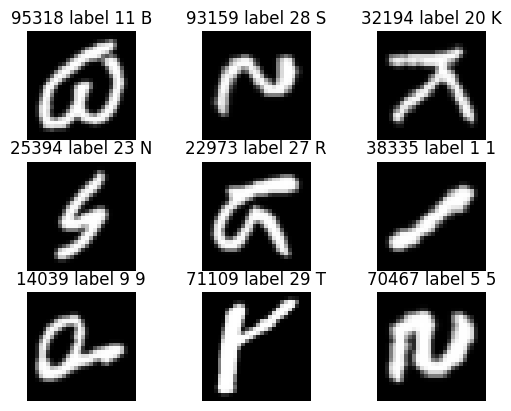

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=3)

for i in  range(3):
  for j in  range(3):
    index = random.randint(0, images_train.shape[0])
    axes[i,j].imshow(images_train[index], cmap='gray')
    axes[i, j].axis('off')
    axes[i, j].set_title(f"{index} label {labels_train[index]} {mapping_dict[labels_train[index]]}")


#### Transposing the images.

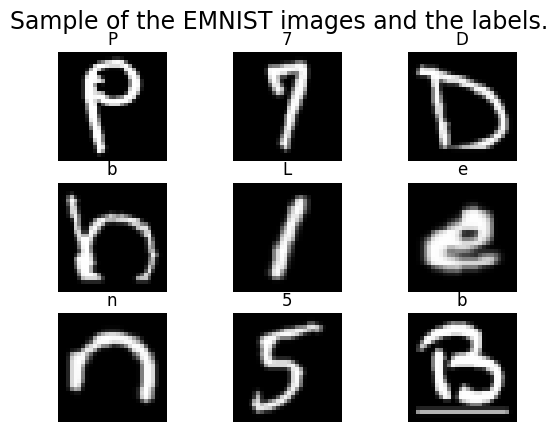

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=3)

for i in  range(3):
  for j in  range(3):
    index = random.randint(0, images_train.shape[0])
    axes[i,j].imshow(images_train[index].T, cmap='gray')
    axes[i, j].axis('off')
    axes[i, j].set_title(f"{mapping_dict[labels_train[index]]}")
fig.suptitle("Sample of the EMNIST images and the labels.", fontsize=17, y=.97)
plt.savefig(join(root_dir, "sample image"))

# Creating the synthetic dataset.

The dataset will be synthesized by concatenating one to five random characters from the dataset to form an image which contains a word of character. It is limited to five as a test case to see how the performance of this approach will be.

Different dataset will be created for each specific number of characters. 10,000 different examples will be created for training for each character length making a total of 50,000 training examples which all be from the training dataset.

The label will be a list containing as many characters as present in the image.

In [ ]:
def syntheze_data(source_images, source_labels, no_character, no_example=10_000, image_height=64, image_width=64, channel=3, transpose=False, normalize=False):
  """
  This function returns that creates word images from character images by concantinating the images together as well as the label of the word as an array of each charater together.
  args:
  source_images ((ndarry))
  source_labels ((ndarry))
  no_character (int) : The length of the character the images that will be concantinated together.
  no_example (int) : The number of examples that will be generated.
  img_height (int), img_width (int) : The height and width of the word images created.
  channel (int) : The channel of the images.
  transpose (bool) : To transpose the image or not.
  normalize (bool) : To normalize the image or not.

  returns:
  synthized_images ((ndarry)) : It contains the synthized images.
  synthized_labels_len ((ndarry)) : It contains the number of characters in the images.
  synthized_labels_char ((ndarry)) : It contains the characters in the images in an ndarray.
  """

  data_len = source_images.shape[0]
  synthized_images = np.zeros((no_example,) + (image_height, image_width, channel))
  synthized_labels_len = np.full((no_example), no_character-1) # Because the model prediction begins at 0
  # synthized_labels_char = np.zeros((no_example, no_character))
  synthized_labels_char = [np.zeros((no_example))] * no_character

  for i in range(no_example):
    # selecting no_examples random indexes from the source_X
    indices = [random.randint(0, data_len-1) for _ in range(no_character)]

    synthized_image_list = []
    for char_pos, index in enumerate(indices):
      synthized_image = source_images[index]

      synthized_image = synthized_image.T if transpose else synthized_image # transposing the image if transpose is set to True
      synthized_image = synthized_image/255. if normalize else synthized_image # normalizing the image if normalize is set to True

      synthized_image_list.append(synthized_image)
      synthized_labels_char[char_pos][i] = source_labels[index]

    # stacking the character images horizontally
    synthized_image = np.hstack(synthized_image_list)

    synthized_image = resize(np.expand_dims(synthized_image, axis=2), (image_height, image_width))
    # synthized_image = resize(synthized_image.reshape(synthized_image.shape + (1,)) , (img_height, img_width))
    synthized_image = synthized_image.numpy()
    synthized_images[i, :, :] = synthized_image
    synthized_labels_char = [synthized_labels_char[i].astype(int) for i in range(no_character)]
    # synthized_labels_char[i, :] = np.array([source_labels[index] for i, index in enumerate(indices)])

  return synthized_images, synthized_labels_len.astype(int), synthized_labels_char

- The dataset for each character length will be stored in a list with the index corresponding to the number of characters. The X list will be of 5 elements of ndarrays of 10,000 images for training and 2,000 for testing each making a total of 50,000 training examples and 10,000 validating examples.  
- There will be two y labels:
-- One for the number of characters in the image. y_len
-- Another for the characters in the image. y_char

The data does not need to be shuffled to introduce randomness, it is introduced from the random selection of the images to generate the synthetic dataset.

In [ ]:
X_train_list, y_len_train_list, y_char_train_list = [], [], []
X_val_list, y_len_val_list, y_char_val_list = [], [], []

for no_character in range(1,MAX_NUMBER_CHARATER+1):
  X_train_temp, y_len_train_temp, y_char_train_temp = syntheze_data(images_train, labels_train, no_character=no_character, no_example=20_000, channel=1, transpose=True, normalize=True)
  X_val_temp, y_len_val_temp, y_char_val_temp = syntheze_data(images_val, labels_val, no_character=no_character, no_example=2000, channel=1, transpose=True, normalize=True)

  X_train_list.append(X_train_temp), y_len_train_list.append(y_len_train_temp), y_char_train_list.append(y_char_train_temp)
  X_val_list.append(X_val_temp), y_len_val_list.append(y_len_val_temp), y_char_val_list.append(y_char_val_temp)

### Visualizing the synthized images and there corresponding words.




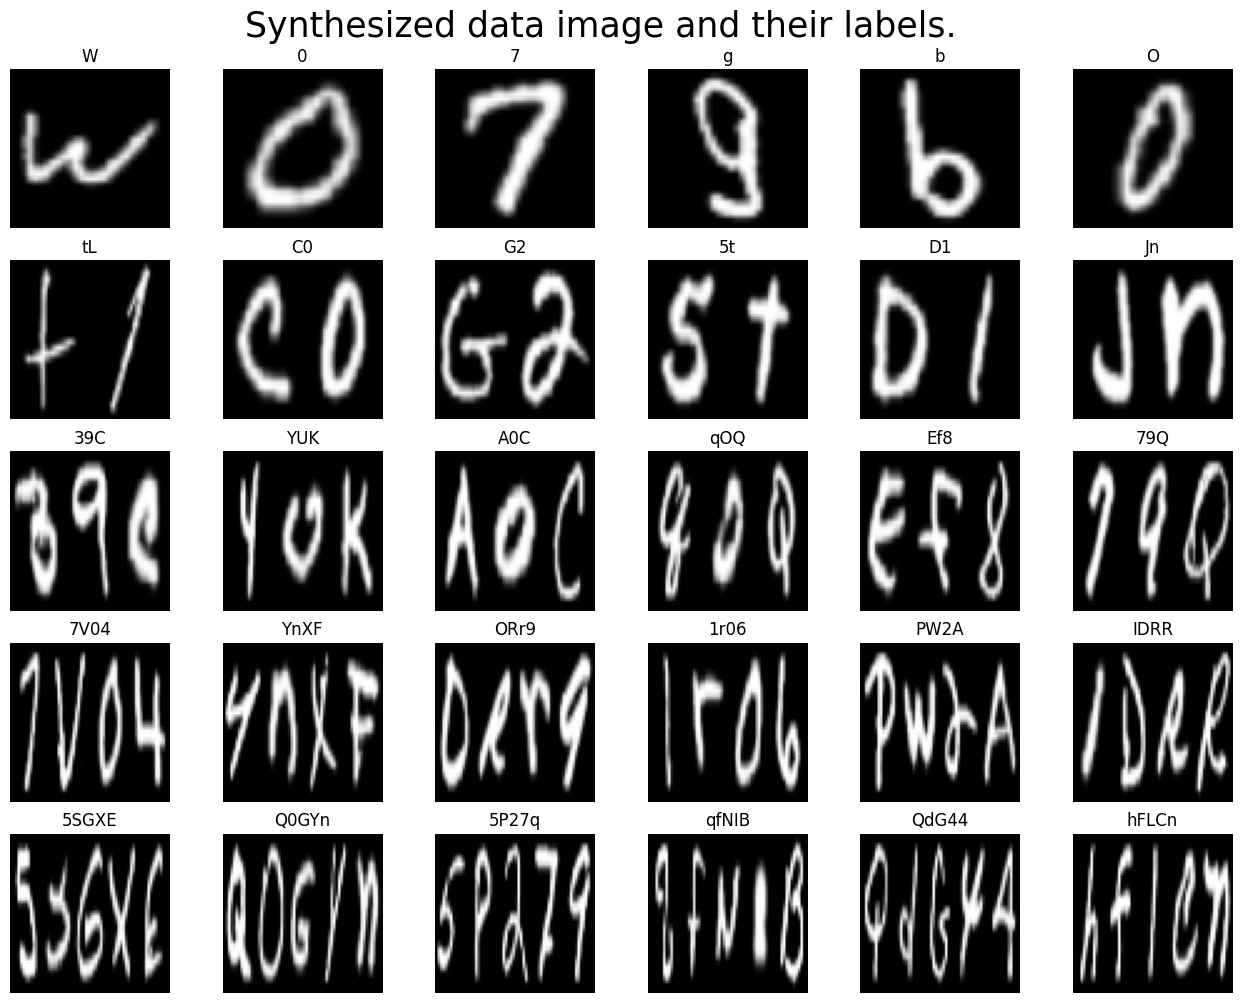

In [ ]:
fig, axes = plt.subplots(5, 6, figsize=(16,12))

for no_character in range(1,MAX_NUMBER_CHARATER+1):
  for j in range(6):
    index = random.randint(0, len(X_train_list[no_character-1])-1)
    axes[no_character-1,j].imshow(X_train_list[no_character-1][index], cmap="gray")
    axes[no_character-1,j].set_title(f"{''.join([mapping_dict[y_char_train_list[no_character-1][char_pos][index]] for char_pos in range(no_character)])}")
    axes[no_character-1,j].axis('off')

fig.suptitle("Synthesized data image and their labels.", fontsize=25, y=.93)
plt.savefig(join(root_dir, "Synthesizef image"))

# Building the model to solve the problem at hand.
The problem is going to be solved in two steps:
- Identifying the number of character present in the image, character_counter model will be used.
- Predicting the characters in the image using the appropriate model based on the number of character presents.

For both model architectures, I will be using an architecture inspired by this [Kaggle published kernel, 2018](https://www.kaggle.com/code/cdeotte/25-million-images-0-99757-mnist/notebook).

It is a convolutional neural network (CNN) architecture. The architecture consists of multiple layers including Conv2D, BatchNormalization, Dropout, Flatten, and Dense layers. The model is configured with specific parameters such as kernel sizes, activation functions, dropout rates, and the number of units in the dense layer. The model is compiled with the Adam optimizer, categorical cross-entropy loss function.

#### Defining necessary parameters for the CNN model.

In [ ]:
batch_size_ccm = 64
epochs_ccm= 100

checkpoint_ccm = ModelCheckpoint(
    filepath=join(model_dir, "character_counter_model-epochs-{epoch}-val_acc{val_acc}.h5"),
    monitor="val_acc",
    mode="max",
    save_best_only=True,
    verbode=1
)

earlystopping_ccm = EarlyStopping(
    monitor="val_acc",
    patience=5,
    mode="max",
    verbose=1
)

## Building the character_counter model.
This model will take in images and try to predict how many characters are present in the image.

In [ ]:
inputs = Input(shape=(image_width, image_height, image_channel))

hidden_layers = Conv2D(filters=32, kernel_size = (3,3), activation="relu")(inputs)
hidden_layers = BatchNormalization()(hidden_layers)
hidden_layers = Conv2D(filters=32, kernel_size = (3,3), activation="relu")(hidden_layers)
hidden_layers = BatchNormalization()(hidden_layers)
hidden_layers = Conv2D(filters=32, kernel_size = (5,5), strides=2, padding="same", activation="relu")(hidden_layers)
hidden_layers = BatchNormalization()(hidden_layers)
hidden_layers = Dropout(0.4)(hidden_layers)

hidden_layers = Conv2D(filters=32, kernel_size = (3,3), activation="relu")(hidden_layers)
hidden_layers = BatchNormalization()(hidden_layers)
hidden_layers = Conv2D(filters=32, kernel_size = (3,3), activation="relu")(hidden_layers)
hidden_layers = BatchNormalization()(hidden_layers)
hidden_layers = Conv2D(filters=32, kernel_size = (5,5), strides=2, padding="same", activation="relu")(hidden_layers)
hidden_layers = BatchNormalization()(hidden_layers)
hidden_layers = Dropout(0.4)(hidden_layers)

hidden_layers = Conv2D(filters=128, kernel_size = (4,4), activation="relu")(hidden_layers)
hidden_layers = BatchNormalization()(hidden_layers)
hidden_layers = Flatten()(hidden_layers)
hidden_layers = Dropout(0.4)(hidden_layers)

no_character_output = Dense(units=MAX_NUMBER_CHARATER, activation="linear", name="ccm_output")(hidden_layers)

character_counter_model = Model(inputs=inputs, outputs=no_character_output, name="character_counter_model")
character_counter_model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(from_logits=True),
                                metrics=["acc"])

In [ ]:
# character_counter_model.summary()

#### Preparing the traing and validating data.

In [ ]:
X_train_ccm, y_train_ccm = np.vstack(X_train_list), np.hstack(y_len_train_list)
X_val_ccm, y_val_ccm = np.vstack(X_val_list), np.hstack(y_len_val_list)

## The character_counter_model Training.

In [ ]:
start_time = time.time()
history_ccm = character_counter_model.fit(X_train_ccm, y_train_ccm, batch_size=batch_size_ccm, epochs=epochs_ccm,
                                      steps_per_epoch = X_train_ccm.shape[0]//batch_size_ccm,
                                      validation_data=(X_val_ccm, y_val_ccm),
                                      callbacks=[checkpoint_ccm,earlystopping_ccm], shuffle=True)
end_time = time.time()

print(f"It took the character_counter_model {end_time - start_time} seconds to train for {epochs_ccm} epochs.")

Epoch 1/100
1562/1562 [==============================] - 63s 34ms/step - loss: 0.0128 - acc: 0.9966 - val_loss: 4.1565e-04 - val_acc: 0.9999
Epoch 2/100
1562/1562 [==============================] - 53s 33ms/step - loss: 0.0075 - acc: 0.9992 - val_loss: 0.0080 - val_acc: 0.9988
Epoch 3/100
1562/1562 [==============================] - 52s 33ms/step - loss: 0.0030 - acc: 0.9997 - val_loss: 0.0271 - val_acc: 0.9977
Epoch 4/100
1562/1562 [==============================] - 52s 34ms/step - loss: 0.0054 - acc: 0.9997 - val_loss: 4.9351e-04 - val_acc: 0.9999
Epoch 5/100
1562/1562 [==============================] - 53s 34ms/step - loss: 0.0049 - acc: 0.9997 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/100
1562/1562 [==============================] - 52s 33ms/step - loss: 0.0067 - acc: 0.9997 - val_loss: 0.0063 - val_acc: 0.9999
Epoch 7/100
1562/1562 [==============================] - 52s 33ms/step - loss: 0.0017 - acc: 0.9999 - val_loss: 2.3524e-05 - val_acc: 1.0000
Epoch 8/100
1562/1562 [==

In [ ]:
# history_ccm.history

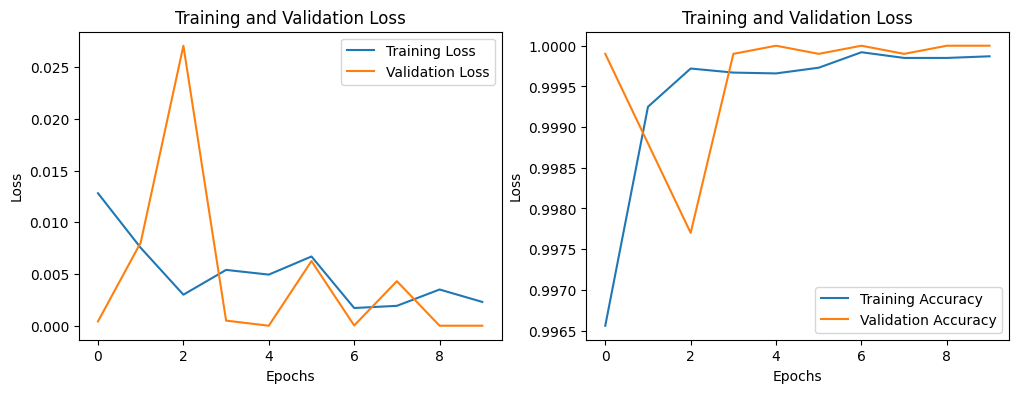

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].plot(history_ccm.history['loss'], label='Training Loss')
ax[0].plot(history_ccm.history['val_loss'], label='Validation Loss')

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()

ax[1].plot(history_ccm.history['acc'], label='Training Accuracy')
ax[1].plot(history_ccm.history['val_acc'], label='Validation Accuracy')

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()

plt.savefig(join(root_dir, "character_count_model_plot"))
plt.show()


In [ ]:
# Saving the character_count model.

character_counter_model.save(join(model_dir, "character_counter_model.h5"))

### Accuracy of character_counter_model
The model has an 100% percent accuracy in predicting the number of characters in a word image.

In [ ]:
def predict_character_count(word_image):
  """Predicts the number of character in a word image"""
  if word_image.ndim == 3:
    word_image = np.expand_dims(word_image, axis=0) # Reshaping the word image from a 3D to a 4D as required by the tf model

  prediction = character_counter_model.predict(word_image, verbose=0)
  pred_index = softmax(prediction).numpy().argmax()
  return pred_index + 1 # Actual number of characters present is index + 1

In [ ]:
def ccm_accuracy(X, y):
  missed_index = []
  for i in range(X.shape[0]):
    pred =  predict_character_count(X[i]) - 1
    if pred != y[i]:
      missed_index.append(i)

  accuracy = 1 - len(missed_index) / X.shape[0]

  return accuracy, missed_index

In [ ]:
accuracy_ccm, missed_index_ccm = ccm_accuracy(X_val_ccm, y_val_ccm)
print(f"character_counter_model acc is {accuracy_ccm*100:.2f}% and missed {len(missed_index_ccm)} of {X_val_ccm.shape[0]}.")

character_counter_model acc is 100.00% and missed 0 of 10000.


The model predicts there is 1 character in the word image shown.


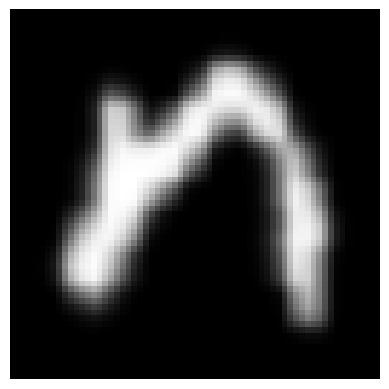

In [ ]:
plt.imshow(X_val_ccm[0], cmap="gray")
plt.axis("off")
print(f"The model predicts there is {predict_character_count(X_val_ccm[0])} character in the word image shown.")

## Inference.
- The model preformed perfectly as expected for predicting the number of characters in a word  with about 4 epochs of training.
- The got an accuracy score of 100% for the validation data of 10,000 images.

## Building the word_predictor model.
This model will take in images and try to predict the character present in the image.
The model will be stored in list with each index corresponding to the no_character-1 the model is predicting.

#### Defining necessary parameters for the CNN model.

In [ ]:
batch_size_wpw = 64
epochs_wpm = 100
checkpoint_wpms = []

for no_character in range(1,MAX_NUMBER_CHARATER+1):
  checkpoint_wpm = ModelCheckpoint(
      filepath=join(model_dir, "word_predictor_models-"+str(no_character)+"no_character-epochs-{epoch}-loss{loss}.h5"),
      monitor="loss",
      mode="min",
      save_best_only=True,
      verbode=1
  )
  checkpoint_wpms.append(checkpoint_wpm)

earlystopping_wpm = EarlyStopping(
    monitor="loss",
    patience=5,
    mode="min",
    verbose=1
)

In [ ]:
word_predictor_models = []

for no_character in range(1,MAX_NUMBER_CHARATER+1):
  inputs = Input(shape=(image_width, image_height, image_channel))

  hidden_layers = Conv2D(filters=32, kernel_size = (3,3), activation="relu")(inputs)
  hidden_layers = BatchNormalization()(hidden_layers)
  hidden_layers = Conv2D(filters=32, kernel_size = (3,3), activation="relu")(hidden_layers)
  hidden_layers = BatchNormalization()(hidden_layers)
  hidden_layers = Conv2D(filters=32, kernel_size = (5,5), strides=2, padding="same", activation="relu")(hidden_layers)
  hidden_layers = BatchNormalization()(hidden_layers)
  hidden_layers = Dropout(0.4)(hidden_layers)

  hidden_layers = Conv2D(filters=32, kernel_size = (3,3), activation="relu")(hidden_layers)
  hidden_layers = BatchNormalization()(hidden_layers)
  hidden_layers = Conv2D(filters=32, kernel_size = (3,3), activation="relu")(hidden_layers)
  hidden_layers = BatchNormalization()(hidden_layers)
  hidden_layers = Conv2D(filters=32, kernel_size = (5,5), strides=2, padding="same", activation="relu")(hidden_layers)
  hidden_layers = BatchNormalization()(hidden_layers)
  hidden_layers = Dropout(0.4)(hidden_layers)

  hidden_layers = Conv2D(filters=128, kernel_size = (4,4), activation="relu")(hidden_layers)
  hidden_layers = BatchNormalization()(hidden_layers)
  hidden_layers = Flatten()(hidden_layers)
  hidden_layers = Dropout(0.4)(hidden_layers)

  character_outputs = []
  for i in range(no_character):
    character_outputs.append(Dense(units=NO_CHARATERS, activation="linear", name=f"wpm_{no_character}_char{i}")(hidden_layers))

  word_predictor_model = Model(inputs=inputs, outputs=character_outputs)
  word_predictor_model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=["acc"])

  word_predictor_models.append(word_predictor_model)
  # print(word_predictor_model.summary())

#### Creating the training and validating data and Model Training.
- 50,000 training examples are created for each no_character.

In [ ]:
 start_time = time.time()

history_wpm_list = []

for no_character in range(1,MAX_NUMBER_CHARATER+1):
  X_train, _, y_train = syntheze_data(images_train, labels_train, no_character=no_character, no_example=50_000, channel=1, transpose=True, normalize=True)
  X_val, _, y_val =syntheze_data(images_test, labels_test, no_character=no_character, no_example=5000, channel=1, transpose=True, normalize=True)

  history = word_predictor_models[no_character-1].fit(X_train, y_train, batch_size=batch_size_wpw, epochs=epochs_wpm,
                                                      steps_per_epoch = X_train.shape[0]//batch_size_wpw, validation_data=(X_val, y_val),
                                                      callbacks=[checkpoint_wpms[no_character-1],earlystopping_wpm])
  history_wpm_list.append(history)
end_time = time.time()

Epoch 1/100
781/781 [==============================] - 26s 33ms/step - loss: 1.4015 - acc: 0.7388 - val_loss: 0.6268 - val_acc: 0.8400
Epoch 2/100
781/781 [==============================] - 26s 33ms/step - loss: 0.6614 - acc: 0.8239 - val_loss: 0.2968 - val_acc: 0.8800
Epoch 3/100
781/781 [==============================] - 26s 33ms/step - loss: 0.4439 - acc: 0.8565 - val_loss: 0.1969 - val_acc: 0.9000
Epoch 4/100
781/781 [==============================] - 26s 33ms/step - loss: 0.3638 - acc: 0.8737 - val_loss: 0.2712 - val_acc: 0.9000
Epoch 5/100
781/781 [==============================] - 26s 33ms/step - loss: 0.3327 - acc: 0.8810 - val_loss: 0.1625 - val_acc: 0.9800
Epoch 6/100
781/781 [==============================] - 26s 33ms/step - loss: 0.3071 - acc: 0.8896 - val_loss: 0.1264 - val_acc: 0.9600
Epoch 7/100
781/781 [==============================] - 26s 33ms/step - loss: 0.2936 - acc: 0.8925 - val_loss: 0.1601 - val_acc: 0.9400
Epoch 8/100
781/781 [==============================] - 

In [ ]:
# Saving the word_predictor models.

for no_character in range(1,MAX_NUMBER_CHARATER+1):
  word_predictor_models[no_character-1].save(join(model_dir, f"word_predictor_models_no_character_{no_character}.h5"))

### Accuracy of word_predictor_predictor_models.

In [ ]:
def predict_word(word_image):
  if word_image.ndim == 3:
    word_image = np.expand_dims(word_image, axis=0) # Reshaping the word image from a 3D to a 4D as required by the tf model.
  no_character = predict_character_count(word_image) # Getting the no of character present in the image to call the appropiate model.
  pred_list = word_predictor_models[no_character-1].predict(word_image, verbose=0) # Gets the a no_character list with 47 predictions each.

  pred_index_list = []
  for char_pos, prediction in enumerate(pred_list):
    pred_index = softmax(prediction).numpy().argmax()
    pred_index_list.append(pred_index)
  return np.array(pred_index_list)

In [ ]:
def wpm_accuracy(X, y):
  missed_index = [] # Stores the indexs of wrongly predicted words.
  individual_counter = 0 # The number of correctly predicted individual character.
  word_counter = 0 # The number of correcttly predicted words.

  for i in range(X.shape[0]):
    pred_array =  predict_word(X[i])

    if pred_array.shape[0] == len(y):
      actual_array = []
      for j in  range(pred_array.shape[0]):
        actual_array.append(y[j][i])

      actual_array = np.array(actual_array)
      # print(pred_array.shape, y[i], np.equal(pred_array, actual_array))

      correct_pred_mask = np.equal(pred_array, actual_array)

      individual_counter += correct_pred_mask.sum()

      if all(correct_pred_mask):
        word_counter += 1
      else:
        missed_index.append(i)
    else:
      missed_index.append(i)

  total_individual_character_size = len(y)*y[0].size
  individual_character_acc = individual_counter/total_individual_character_size
  word_acc = word_counter/y[0].size

  return individual_character_acc, word_acc, missed_index

In [ ]:
individual_character_acc_list, word_acc_list, missed_index_list = [], [], []
X_val_list, y_val_list = [], []

for no_character in range(1,MAX_NUMBER_CHARATER+1):
  X_val, _, y_val = syntheze_data(images_val, labels_val, no_character=no_character, no_example=2000, channel=1, transpose=True, normalize=True)

  individual_character_acc,  word_acc, missed_index = wpm_accuracy(X_val, y_val)
  individual_character_acc_list.append(individual_character_acc), word_acc_list.append(word_acc), missed_index_list.append(missed_index)
  print(f"word_predictor_models no_character {no_character}: indiviual character accuracy - {individual_character_acc*100:.2f}%, word accuracy - {word_acc*100:.2f}%,  missed {len(missed_index)}") # of {X_val.shape[0]}")
  X_val_list.append(X_val), y_val_list.append(y_val)

word_predictor_models no_character 1: indiviual character accuracy - 85.05%, word accuracy - 85.05%,  missed 299
word_predictor_models no_character 2: indiviual character accuracy - 87.72%, word accuracy - 77.10%,  missed 458
word_predictor_models no_character 3: indiviual character accuracy - 86.18%, word accuracy - 64.25%,  missed 715
word_predictor_models no_character 4: indiviual character accuracy - 85.88%, word accuracy - 54.85%,  missed 903
word_predictor_models no_character 5: indiviual character accuracy - 83.82%, word accuracy - 41.85%,  missed 1163


## Inference.

- The models have an average individual character prediction accuracy of 85.73%.
- As the number of characters in the image to be predicted increases, the word accuracy decreases. The relationship observed is the word prediction accuracy for predicting an image with n numbers of characters is about (85.73%)^n.
-- For n = 1, acc = 85.05%.
-- For n = 3, acc = 64.25%, (85.73%)^3 = 63%.
- This relationship is borne out of the multiplicative effect of compounding characters together.

### Visualizing the model's wrong predictions.

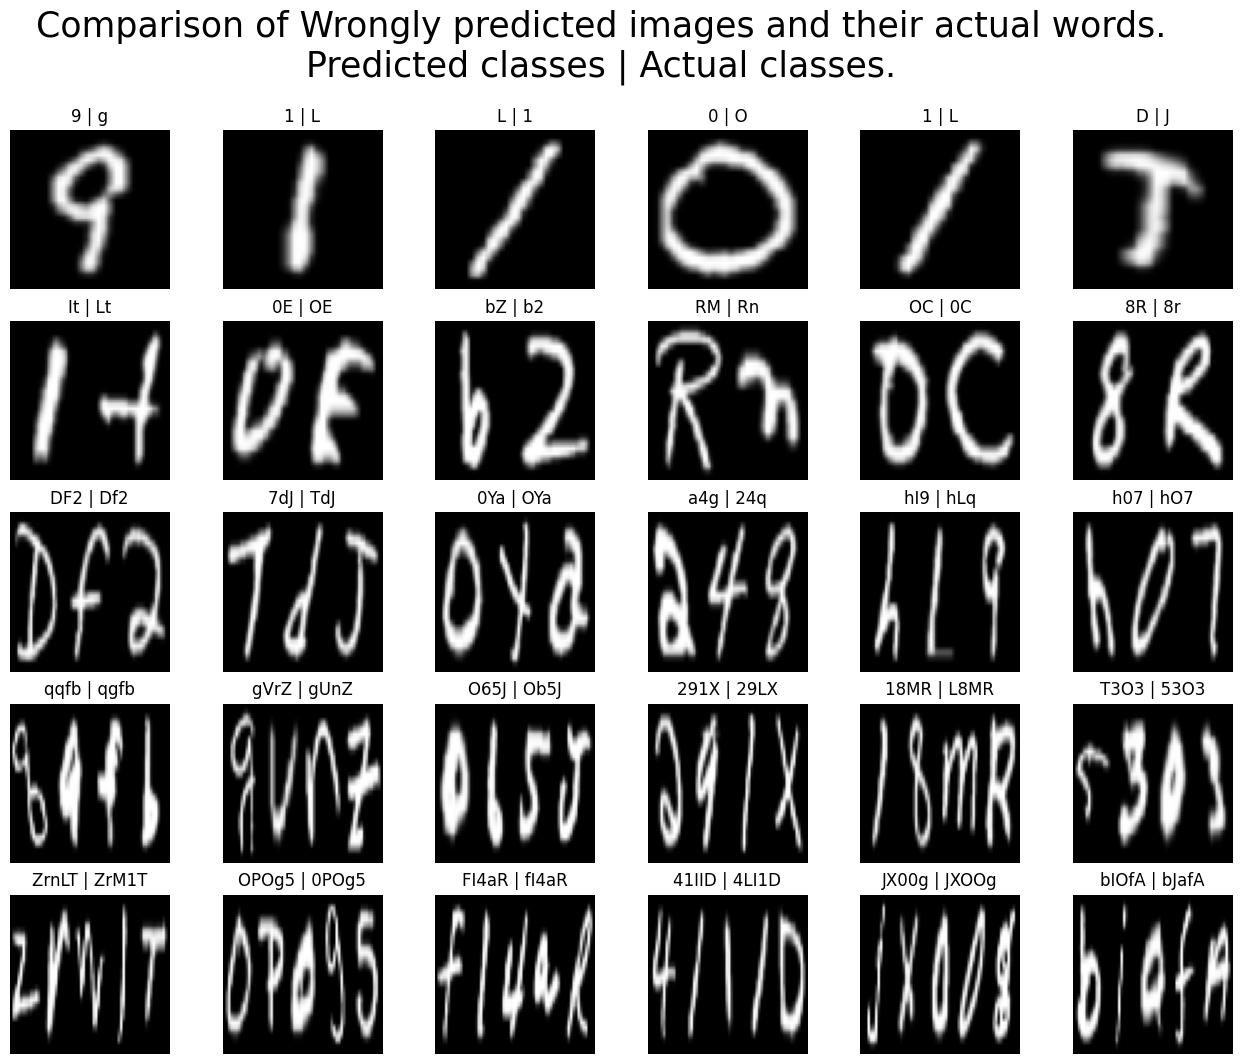

In [ ]:
fig, axes = plt.subplots(5, 6, figsize=(16,12))

for no_character in range(1,MAX_NUMBER_CHARATER+1):
  for j in range(6):
    index = random.choice(missed_index_list[no_character-1])
    axes[no_character-1,j].imshow(X_val_list[no_character-1][index], cmap="gray")
    axes[no_character-1,j].set_title(f"{''.join([mapping_dict[char_index] for char_index in predict_word(X_val_list[no_character-1][index])])} | {''.join([mapping_dict[y_val_list[no_character-1][char_pos][index]] for char_pos in range(no_character)])}")
    # axes[no_character-1,j].set_title(f"{''.join([mapping_dict[y_val_list[no_character-1][char_pos][index]] for char_pos in range(no_character)])}")
    axes[no_character-1,j].axis('off')

fig.suptitle("Comparison of Wrongly predicted images and their actual words.\nPredicted classes | Actual classes.",
             fontsize=25, y=.98)
plt.savefig(join(root_dir, "worng image"))

## Inference.
For observation of a few of the wrongly predicted images. most of the wrong predictions were due to character which are very similar and hard to distinguish even for human sometime like f anf F, l, I and L, U and V, 0 and O, q, g and y, 6 and G and serval more
This account for the model's relatively low accuracy score of about 85.7%.

# Results and Conclusion
The word predictor models achieve an average individual character prediction accuracy of approximately 85.7%. However, as the number of characters in the word increases, the accuracy decreases. This is because the complexity of distinguishing similar characters compounds when predicting longer words.

Despite the challenges, the models perform well in predicting words from images. Some errors are observed due to the similarity between certain characters, such as ('f' and 'F'), ('U' and 'V'), ('l', 'I' and 'L'), ('0', 'O' and 'D'), ('q', 'g', and 'y'), ('b', '6' and 'G') e.t.c. These similarities contribute to the model's relatively lower accuracy score of approximately 85.7%.

In conclusion, this project demonstrates the effectiveness of convolutional neural network models for character and word recognition using the EMNIST dataset. The models' performance could be further improved by exploring more sophisticated architectures and data augmentation techniques. Overall, this project showcases the potential of computer vision in solving real-world problems and provides valuable insights into character recognition tasks.